In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools

In [2]:
num_epochs = 30
batch_size = 128
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
lambda_gp = 10.0

device_name = 'CPU:0'

tf.random.set_seed(1)
np.random.seed(1)

In [3]:
def build_generator(z_size=20, output_size=(28, 28, 1), n_filters=128, n_blocks=2):
    size_factor = 2**n_blocks
    hidden_size = (
        output_size[0] // size_factor,
        output_size[1] // size_factor,
    )

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(z_size,)),
        tf.keras.layers.Dense(units=n_filters*np.prod(hidden_size), use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((hidden_size[0], hidden_size[1], n_filters)),
        tf.keras.layers.Conv2DTranspose(filters=n_filters, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
    ])

    nf = n_filters
    for i in range(n_blocks):
        nf //= 2

        model.add(tf.keras.layers.Conv2DTranspose(filters=nf, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(filters=output_size[2], kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

def build_discriminator(input_size=(28, 28, 1), n_filters=64, n_blocks=2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_size),
        tf.keras.layers.Conv2D(filters=n_filters, kernel_size=5, strides=(1, 1), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
    ])

    nf = n_filters
    for i in range(n_blocks):
        nf *= 2

        model.add(tf.keras.layers.Conv2D(filters=nf, kernel_size=(5, 5), strides=(2, 2), padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(7, 7), padding='valid'))
    model.add(tf.keras.layers.Reshape((1, )))

    return model

In [4]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image

In [5]:
gen_model = build_generator()
gen_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       125,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6272)           │        25,088 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       409,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 32)     │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 1)      │           800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 817,824 (3.12 MB)

 Trainable params: 804,832 (3.07 MB)

 Non-trainable params: 12,992 (50.75 KB)

In [6]:
disc_model = build_discriminator()
disc_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 1)        │        12,545 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,040,385 (3.97 MB)

 Trainable params: 1,039,489 (3.97 MB)

 Non-trainable params: 896 (3.50 KB)

In [7]:
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

with tf.device(device_name):
    gen_model = build_generator()
    gen_model.build(input_shape=(None, z_size))
    gen_model.summary()

    disc_model = build_discriminator()
    disc_model.build()
    disc_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 6272)           │       125,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 6272)           │        25,088 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 7, 7, 128)      │       409,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 28, 28, 32)     │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 1)      │           800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 817,824 (3.12 MB)

 Trainable params: 804,832 (3.07 MB)

 Non-trainable params: 12,992 (50.75 KB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1, 1, 1)        │        12,545 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,040,385 (3.97 MB)

 Trainable params: 1,039,489 (3.97 MB)

 Non-trainable params: 896 (3.50 KB)

In [8]:
g_optimizer = tf.keras.optimizers.Adam(0.0002)
d_optimizer = tf.keras.optimizers.Adam(0.0002)

if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))

def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

all_losses = []
epoch_samples = []

start_time = time.time()

for epoch in range(1, num_epochs+1):
    epoch_losses = []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            g_output = gen_model(input_z, training=True)
            
            d_critics_real = disc_model(input_real, training=True)
            d_critics_fake = disc_model(g_output, training=True)

            g_loss = -tf.math.reduce_mean(d_critics_fake)

            d_loss_real = -tf.math.reduce_mean(d_critics_real)
            d_loss_fake =  tf.math.reduce_mean(d_critics_fake)
            d_loss = d_loss_real + d_loss_fake

            with tf.GradientTape() as gp_tape:
                alpha = tf.random.uniform(
                    shape=[d_critics_real.shape[0], 1, 1, 1], 
                    minval=0.0, maxval=1.0)
                interpolated = (
                    alpha*input_real + (1-alpha)*g_output)
                gp_tape.watch(interpolated)
                d_critics_intp = disc_model(interpolated)
            
            grads_intp = gp_tape.gradient(
                d_critics_intp, [interpolated,])[0]
            grads_intp_l2 = tf.sqrt(
                tf.reduce_sum(tf.square(grads_intp), axis=[1, 2, 3]))
            grad_penalty = tf.reduce_mean(tf.square(grads_intp_l2 - 1.0))
        
            d_loss = d_loss + lambda_gp*grad_penalty
        
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
        
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
                    
    all_losses.append(epoch_losses)
    
    print('Epoch {:-3d} | ET {:.2f} min | Avg Losses >>'
          ' G/D {:6.2f}/{:6.2f} [D-Real: {:6.2f} D-Fake: {:6.2f}]'
          .format(epoch, (time.time() - start_time)/60, 
                  *list(np.mean(all_losses[-1], axis=0)))
    )
    
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy()
    )

Epoch   1 | ET 7.78 min | Avg Losses >> G/D 326.65/-599.79 [D-Real: -337.86 D-Fake: -326.65]
Epoch   2 | ET 15.45 min | Avg Losses >> G/D 303.02/-194.27 [D-Real: -227.77 D-Fake: -303.02]
Epoch   3 | ET 23.08 min | Avg Losses >> G/D 208.08/-85.83 [D-Real: -115.95 D-Fake: -208.08]
Epoch   4 | ET 30.74 min | Avg Losses >> G/D 149.42/ 15.13 [D-Real: -52.85 D-Fake: -149.42]
Epoch   5 | ET 38.45 min | Avg Losses >> G/D 102.89/ -1.96 [D-Real:  -6.32 D-Fake: -102.89]
Epoch   6 | ET 46.17 min | Avg Losses >> G/D  80.40/-14.16 [D-Real:   3.13 D-Fake: -80.40]
Epoch   7 | ET 53.92 min | Avg Losses >> G/D  70.59/-16.18 [D-Real:  20.30 D-Fake: -70.59]
Epoch   8 | ET 61.60 min | Avg Losses >> G/D  86.48/-24.57 [D-Real:  39.31 D-Fake: -86.48]
Epoch   9 | ET 69.29 min | Avg Losses >> G/D  66.90/-19.49 [D-Real:  28.08 D-Fake: -66.90]
Epoch  10 | ET 76.94 min | Avg Losses >> G/D  68.43/-41.99 [D-Real:  17.20 D-Fake: -68.43]
Epoch  11 | ET 84.69 min | Avg Losses >> G/D 107.88/-38.06 [D-Real:  54.88 D-Fake

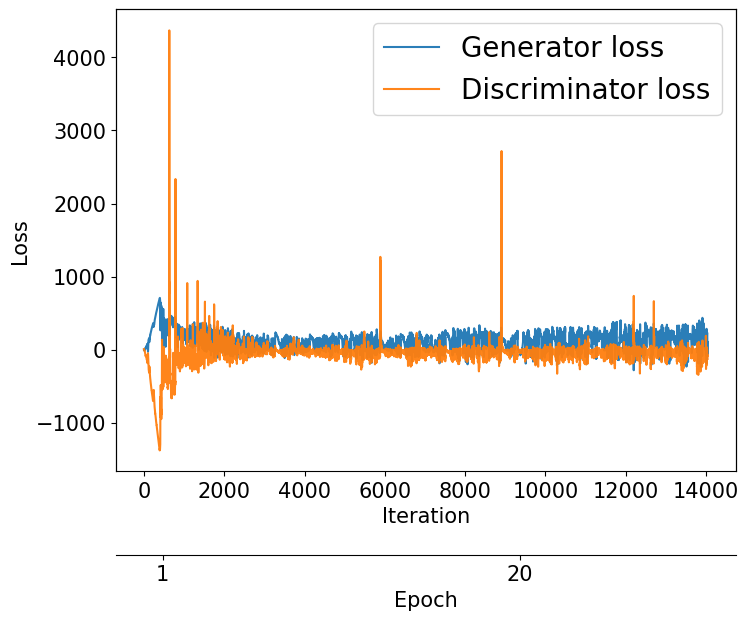

In [9]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(1, 1, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1] for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos   = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.show()

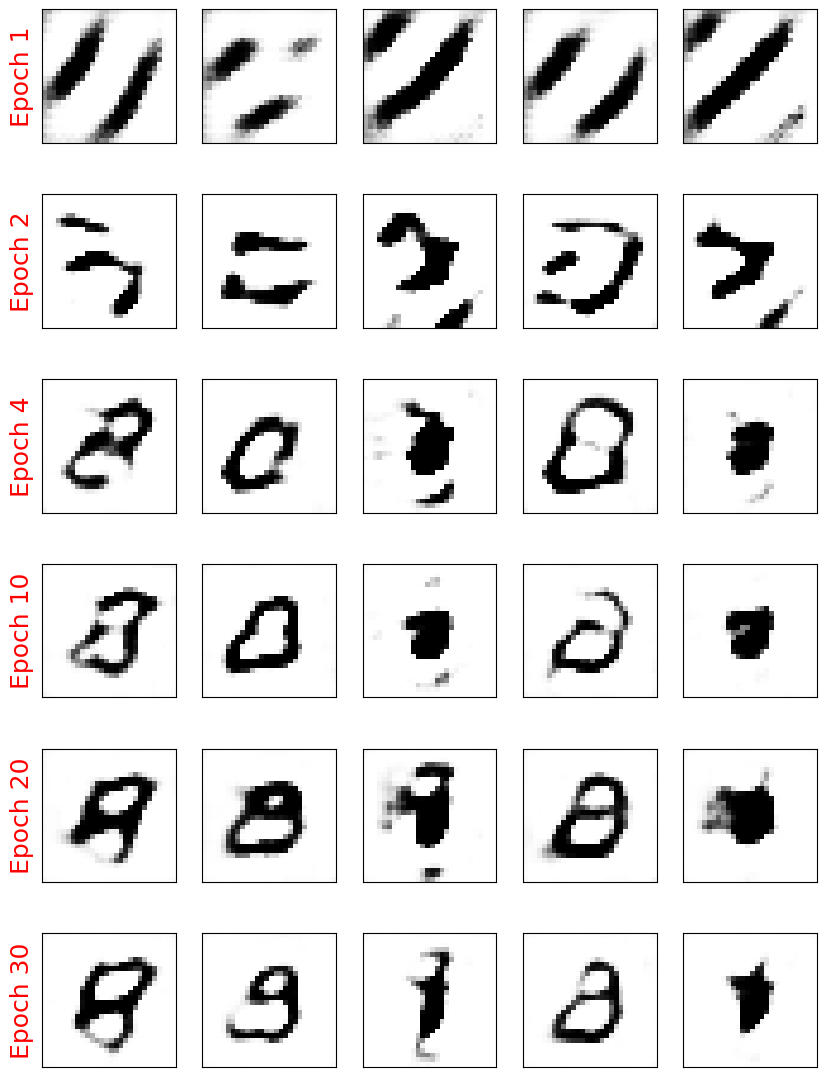

In [11]:
selected_epochs = [1, 2, 4, 10, 20, 30]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.show()